<a href="https://colab.research.google.com/github/awaisnazir08/Sparks-Foundation-Computer-Vision-Internship/blob/main/train_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

In [3]:
os.chdir('/content/drive/MyDrive/Face Mask')

In [4]:
ls

train_mask_detector.ipynb


In [6]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3770, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3770 (delta 2), reused 1 (delta 0), pack-reused 3764
Receiving objects: 100% (3770/3770), 143.05 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (3840/3840), done.


In [7]:
cd Face-Mask-Detection/

/content/drive/MyDrive/Face Mask/Face-Mask-Detection


In [9]:
ls

dataset/              face_detector/       plot.png          train_mask_detector.ipynb
detect_mask_video.py  mask_detector.model  requirements.txt  train_mask_detector.py


In [10]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 25.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [12]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [13]:
DIRECTORY = '/content/drive/MyDrive/Face Mask/Face-Mask-Detection/dataset'

CATEGORIES = ["with_mask", "without_mask"]

In [17]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

[INFO] loading images...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [18]:


# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [20]:

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)



[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 55s 483ms/step - loss: 0.4548 - accuracy: 0.8111 - val_loss: 0.1827 - val_accuracy: 0.9739
Epoch 2/20
95/95 [==============================] - 40s 422ms/step - loss: 0.1636 - accuracy: 0.9657 - val_loss: 0.0887 - val_accuracy: 0.9857
Epoch 3/20
95/95 [==============================] - 43s 454ms/step - loss: 0.1033 - accuracy: 0.9740 - val_loss: 0.0602 - val_accuracy: 0.9896
Epoch 4/20
95/95 [==============================] - 39s 408ms/step - loss: 0.0879 - accuracy: 0.9769 - val_loss: 0.0504 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 40s 417ms/step - loss: 0.0649 - accuracy: 0.9812 - val_loss: 0.0429 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 40s 419ms/step - loss: 0.0576 - accuracy: 0.9855 - val_loss: 0.0392 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 39s 412ms/step - loss: 0.0545 - accuracy

[INFO] evaluating network...
24/24 [==============================] - 3s 83ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


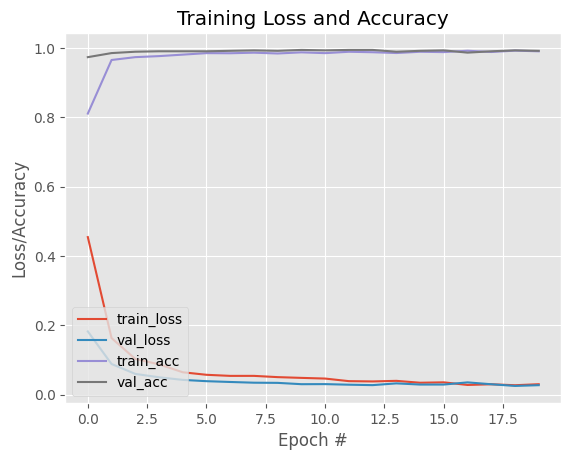

In [21]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [22]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
